# Test of CSBM

In [1]:
import torch
from torch_geometric.data import Data

In [2]:
import numpy as np
from collections import Counter

In [3]:
import matplotlib.pyplot as plt

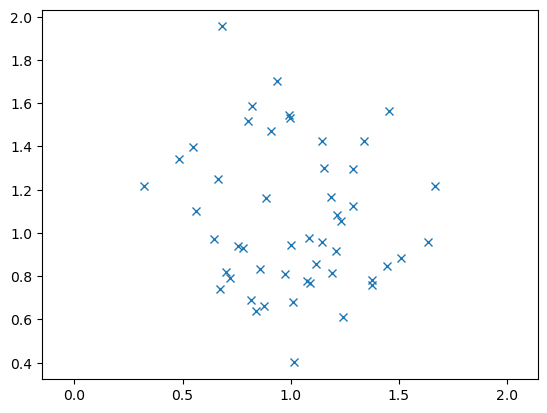

In [4]:
m = [1, 1]
sigma_square = 0.1
cv = np.eye(2) * sigma_square
x, y = np.random.multivariate_normal(m, cv, 50).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [5]:
import networkx as nx
import torch_geometric

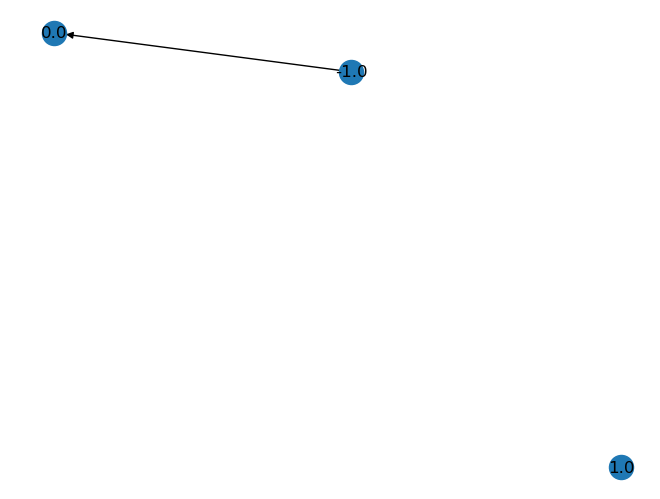

In [6]:
edge_index = torch.tensor([[0],
                          [1]], dtype=torch.long)
#edge_index.add(torch.tensor([[1], [1]], dtype=torch.long))
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
labeld = {node: val for node, val in enumerate(list(x.numpy().flatten()))}
nx.draw(g, labels=labeld, with_labels=True)

In [7]:
edge_index

tensor([[0],
        [1]])

In [8]:
from MultiClassCSBM import MultiClassCSBM

In [12]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
csbm = MultiClassCSBM()

<class 'torch_geometric.datasets.planetoid.Planetoid'>
<class 'MultiClassCSBM.MultiClassCSBM'>


In [13]:
print(type(dataset))
print(type(csbm.graph))

<class 'torch_geometric.datasets.planetoid.Planetoid'>
<class 'torch_geometric.data.data.Data'>
